### External imports

In [1]:
#%matplotlib widget

# imports
import sys
import os
sys.path.append(os.path.join(os.path.dirname(''), '..'))
from testrun import test_runner
test_runner()


import numpy as np
from numpy.lib.stride_tricks import as_strided
import cupy as cp
from scipy import signal, misc

import math
import time
import importlib

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


### Internal Imports

In [2]:
from pycompute.plot import plot_utility as pu

### Create - Data, Consts, Pars, Lower Bound, Upper Bound

In [3]:
nparam = 4

slice_start = 15
slice_stop = 35

# Data
data = None
with open('data_ivim.npy', 'rb') as f:
    data = np.load(f)[:,:,slice_start:slice_stop,:]
data = np.nan_to_num(data, posinf=0.0, neginf=0.0)

nvoxels = data.shape[0] * data.shape[1] * data.shape[2]
ndata = data.shape[3]
data_flat = np.transpose(data, (3,0,1,2)).flatten().reshape((ndata,nvoxels), order='C')
#   data_flat = np.tile(np.reshape(np.array([908.02686, 905.39154, 906.08997, 700.7829, 753.0848, 859.9136,
#  	   870.48846, 755.96893, 617.3499, 566.2044 , 746.62067, 662.47424,
#  	   628.8806, 459.7746 , 643.30554, 318.58453, 416.5493, 348.34335,
#  	   411.74026, 284.17468, 290.30487], dtype=np.float32), (1,21)), (1,nvoxels))
#data_flat[:,0] = np.array([908.02686, 905.39154, 906.08997, 700.7829, 753.0848, 859.9136,
#  	   870.48846, 755.96893, 617.3499, 566.2044 , 746.62067, 662.47424,
#  	   628.8806, 459.7746 , 643.30554, 318.58453, 416.5493, 348.34335,
#  	   411.74026, 284.17468, 290.30487], dtype=np.float32)

# Consts
consts = None
with open('bvals_ivim.npy', 'rb') as f:
    consts = np.load(f).astype(cp.float32)
consts = np.reshape(consts, (1,21,1))
consts_flat = np.tile(consts, (1, 1, nvoxels))

# Pars
pars_dipy = None
with open('pars_ivim_dipytrr.npy', 'rb') as f:
    pars_dipy = np.load(f)[:,:,slice_start:slice_stop,:]
pars_dipy = np.nan_to_num(pars_dipy, posinf=0.0, neginf=0.0)

#pars_flat = np.transpose(pars_dipy.copy(), (3,0,1,2)).reshape((nparam,nvoxels),order='C')
pars_flat = cp.empty((nparam, nvoxels), dtype=np.float32)
#pars_flat[0,:] = 10000 #pars_dipy[:,:,:,0].flatten()
#pars_flat[1,:] = 0.5 #pars_dipy[:,:,:,1].flatten()
#pars_flat[2,:] = 0.005 #pars_dipy[:,:,:,2].flatten()
#pars_flat[3,:] = 0.0005 #pars_dipy[:,:,:,3].flatten()

lower_bound = cp.empty((nparam, nvoxels), dtype=np.float32)
lower_bound[0,:] = 0
lower_bound[1,:] = 1e-3
lower_bound[2,:] = 1e-6
lower_bound[3,:] = 1e-8

upper_bound = cp.empty((nparam, nvoxels), dtype=np.float32)
upper_bound[0,:] = 20000
upper_bound[1,:] = 0.999
upper_bound[2,:] = 0.1
upper_bound[3,:] = 0.02

In [4]:
from pycompute.cuda import lsq as clsq
from pycompute.cuda import lsqnonlin as cnlsq
importlib.reload(clsq)


lower_sol = clsq.bpolyfit(cp.array(-consts_flat[:,0:10,:]), cp.log(cp.array(data_flat[0:10,:])), 1, cp.float32)
upper_sol = clsq.bpolyfit(cp.array(-consts_flat[:,15:,:]), cp.log(cp.array(data_flat[15:,:])), 1, cp.float32)

lower_sol[0,:] = cp.exp(lower_sol[0,:])
upper_sol[0,:] = cp.exp(upper_sol[0,:])

pars_flat[0,:] = cp.nan_to_num(lower_sol[0,:], posinf=0.0, neginf=0.0)
pars_flat[1,:] = cp.nan_to_num((1.0 - (upper_sol[0,:] / lower_sol[0,:])), posinf=0.0, neginf=0.0)
pars_flat[2,:] = cp.nan_to_num(lower_sol[1,:], posinf=0.0, neginf=0.0)
pars_flat[3,:] = cp.nan_to_num(upper_sol[1,:], posinf=0.0, neginf=0.0)

pars_flat[0,:] = cp.clip(cp.asarray(pars_flat[0,:]), lower_bound[0,:], upper_bound[0,:])
pars_flat[1,:] = cp.clip(cp.asarray(pars_flat[1,:]), lower_bound[1,:], upper_bound[1,:])
pars_flat[2,:] = cp.clip(cp.asarray(pars_flat[2,:]), lower_bound[2,:], upper_bound[2,:])
pars_flat[3,:] = cp.clip(cp.asarray(pars_flat[3,:]), lower_bound[3,:], upper_bound[3,:])


In [5]:
plot_linearizations = False
if plot_linearizations:
    pu.plot_matrix(lower_sol[0,:].get().reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())
    pu.plot_matrix(lower_sol[1,:].get().reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())
    pu.plot_matrix(upper_sol[0,:].get().reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())
    pu.plot_matrix(upper_sol[1,:].get().reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())

In [6]:
plot_segmented = False
if plot_segmented:
    pu.plot_matrix(pars_flat[0,:].reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())
    pu.plot_matrix(pars_flat[1,:].reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())
    pu.plot_matrix(pars_flat[2,:].reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())
    pu.plot_matrix(pars_flat[3,:].reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())

In [7]:
do_full_plot = False

In [8]:
# lower_bound[0,:] = 0
# upper_bound[0,:] = 25000

# lower_bound[1,:] = 0.001
# upper_bound[1,:] = 0.999

# lower_bound[2,:] = 1e-6
# upper_bound[2,:] = 0.1

# lower_bound[3,:] = 1e-8
# upper_bound[3,:] = 0.02

lower_bound[0,:] = cp.maximum(cp.array(pars_flat[0,:]) / 2, 500)
upper_bound[0,:] = cp.minimum(cp.array(pars_flat[0,:]) * 2, 20000)

lower_bound[1,:] = cp.maximum(cp.array(pars_flat[1,:]) - 0.4, 0.001)
upper_bound[1,:] = cp.minimum(cp.array(pars_flat[1,:]) + 0.4, 0.999)

lower_bound[2,:] = cp.maximum(cp.array(pars_flat[2,:]) / 200.0, 1e-6)
upper_bound[2,:] = cp.minimum(cp.array(pars_flat[2,:]) * 200.0, 0.1)

lower_bound[3,:] = cp.maximum(cp.array(pars_flat[3,:]) / 200.0, 1e-8)
upper_bound[3,:] = cp.minimum(cp.array(pars_flat[3,:]) * 200.0, 0.02)


In [9]:
from pycompute.cuda import lsqnonlin as clsqn
importlib.reload(clsqn)

expr = 'S0*(f*exp(-b*D_1)+(1-f)*exp(-b*D_2))'
pars_str = ['S0', 'f', 'D_1', 'D_2']
consts_str = ['b']

constscu = cp.array(consts_flat, dtype=cp.float32, copy=True, order='C')
datacu = cp.array(data_flat, dtype=cp.float32, copy=True, order='C')
lower_bound_cu = cp.array(lower_bound, dtype=cp.float32, copy=True, order='C')
upper_bound_cu = cp.array(upper_bound, dtype=cp.float32, copy=True, order='C')

solm = clsqn.RandomSearch(expr, pars_str, consts_str, ndata, cp.float32, write_to_file=True)
solm.setup(constscu, datacu, lower_bound_cu, upper_bound_cu)
solm.run(500)

pars_flat = solm.best_pars_t

In [10]:
from pycompute.cuda import lsqnonlin as clsqn
importlib.reload(clsqn)

expr = 'S0*(f*exp(-b*D_1)+(1-f)*exp(-b*D_2))'
pars_str = ['S0', 'f', 'D_1', 'D_2']
consts_str = ['b']

constscu = cp.array(consts_flat, dtype=cp.float32, copy=True, order='C')
datacu = cp.array(data_flat, dtype=cp.float32, copy=True, order='C')
lower_bound_cu = cp.array(lower_bound, dtype=cp.float32, copy=True, order='C')
upper_bound_cu = cp.array(upper_bound, dtype=cp.float32, copy=True, order='C')

solm = clsqn.SecondOrderRandomSearch(expr, pars_str, consts_str, ndata, cp.float32, write_to_file=True)
solm.setup(constscu, datacu, lower_bound_cu, upper_bound_cu)
solm.run(100, lm_iters=10)

pars_flat = solm.best_pars_t

In [11]:
if do_full_plot:
	pu.plot_matrix(pars_flat[0,:].reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())
	time.sleep(0.1)
	pu.plot_matrix(pars_flat[1,:].reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())
	pu.plot_matrix(pars_flat[2,:].reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())
	pu.plot_matrix(pars_flat[3,:].reshape((data.shape[0], data.shape[1], data.shape[2]))[:,:,0].get())

In [12]:
if do_full_plot:
	importlib.reload(pu)

	plotposx = round(data.shape[0]/2)+30
	plotposy = round(data.shape[1]/2)+10

	pars_to_plot = pars_flat.reshape((nparam, data.shape[0], data.shape[1], data.shape[2]))[:,plotposx,plotposy,0].get()
	pars_dipy_to_plot = pars_dipy[plotposx,plotposy,0,:]
	data_to_plot = np.reshape(data[plotposx,plotposy,0,:], (1,21))
	print('pars:        ', pars_to_plot)
	print('pars_dipy:   ', pars_dipy_to_plot)
	print('data:        ', data_to_plot)
	print('lower_bound: ', lower_bound.reshape((nparam, data.shape[0], data.shape[1], data.shape[2]))[:,plotposx,plotposy,0])
	print('upper_bound: ', upper_bound.reshape((nparam, data.shape[0], data.shape[1], data.shape[2]))[:,plotposx,plotposy,0])

	f1 = pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_to_plot, consts.reshape((1,21)), data_to_plot)
	f2 = pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_dipy_to_plot, consts.reshape((1,21)), data_to_plot)

	print(f1)
	print(f2)


In [13]:
if do_full_plot:
	importlib.reload(pu)

	mask = data[:,:,:,0] > 3000
	#pu.plot_matrix(mask[:,:,10].astype(np.float32))
	pu.animate_matrix(mask.astype(np.float32), fps=10)


In [14]:
from pycompute.cuda import lsqnonlin as clsqn
importlib.reload(clsqn)

expr = 'S0*(f*exp(-b*D_1)+(1-f)*exp(-b*D_2))'
pars_str = ['S0', 'f', 'D_1', 'D_2']
consts_str = ['b']

first_f = np.empty((1, nvoxels), dtype=np.float32)
last_f = np.empty((1, nvoxels), dtype=np.float32)

solm = clsqn.SecondOrderLevenbergMarquardt(expr, pars_str, consts_str, ndata=ndata, dtype=cp.float32, write_to_file=True)

start = time.time()

parscu = cp.array(pars_flat, dtype=cp.float32, copy=True, order='C')
constscu = cp.array(consts_flat, dtype=cp.float32, copy=True, order='C')
datacu = cp.array(data_flat, dtype=cp.float32, copy=True, order='C')
lower_bound_cu = cp.array(lower_bound, dtype=cp.float32, copy=True, order='C')
upper_bound_cu = cp.array(upper_bound, dtype=cp.float32, copy=True, order='C')

solm.setup(parscu, constscu, datacu, lower_bound_cu, upper_bound_cu)
parscu = solm.run(50, 1e-10)

cp.cuda.stream.get_current_stream().synchronize()
end = time.time()

first_f = solm.first_f.get()
last_f = solm.last_f.get()

pars_flat = solm.pars_t.get()

print('It took: ' + str(end - start) + ' s')

It took: 0.7992308139801025 s


In [15]:
if do_full_plot:
	ffig1 = plt.figure()
	fax1 = ffig1.add_axes([0,0,1,1])
	ffigdata1 = fax1.imshow(np.reshape(first_f, (data.shape[0], data.shape[1], data.shape[2]))[:,:,0])
	fax1.set_title('First Objective Functions')
	ffigdata1.set_clim(0.0, 1e9)
	ffig1.colorbar(ffigdata1, ax=fax1)

	ffig2 = plt.figure()
	fax2 = ffig2.add_axes([0,0,1,1])
	ffigdata2 = fax2.imshow(np.reshape(last_f, (data.shape[0], data.shape[1], data.shape[2]))[:,:,0])
	fax2.set_title('Last Objective Functions')
	ffigdata2.set_clim(0.0, 1e9)
	ffig2.colorbar(ffigdata2, ax=fax2)

	ffig3 = plt.figure()
	fax3 = ffig3.add_axes([0,0,1,1])
	ffigdata3 = fax3.imshow(np.sqrt(np.reshape(solm.step_type_t.get().astype(np.float32), (data.shape[0], data.shape[1], data.shape[2]))[:,:,0]))
	fax3.set_title('StepType')
	ffigdata3.set_clim(0, 4)
	ffig3.colorbar(ffigdata3, ax=fax3)

In [16]:
pars_flat_back = np.transpose(np.reshape(pars_flat, (4, data.shape[0], data.shape[1], data.shape[2])), (1,2,3,0))


In [17]:
gemask = pars_flat_back[:,:,:,2] < pars_flat_back[:,:,:,3]

temp = pars_flat_back[gemask, 2].copy()
pars_flat_back[gemask, 2] = pars_flat_back[gemask, 3].copy()
pars_flat_back[gemask, 3] = temp.copy()
pars_flat_back[gemask, 1] = 1 - pars_flat_back[gemask, 1]


In [18]:
if do_full_plot:
	#param_printer(pars, print_S0=True)
	pu.param_plotter(pars_dipy, slicez=0, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[0])

	pu.param_plotter(pars_flat_back, slicez=0, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[0])


In [19]:
if do_full_plot:
	#param_printer(pars, print_S0=True)
	pu.param_plotter(pars_dipy, slicez=0, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[1])

	pu.param_plotter(pars_flat_back, slicez=0, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[1])


In [20]:
if do_full_plot:
	#param_printer(pars, print_S0=True)
	pu.param_plotter(pars_dipy, slicez=0, clim=[0.0, 0.5], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[2])

	pu.param_plotter(pars_flat_back, slicez=0, clim=[0.0, 0.5], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[2])

In [21]:
if do_full_plot:
	#param_printer(pars, print_S0=True)
	pu.param_plotter(pars_dipy, slicez=0, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[3])

	pu.param_plotter(pars_flat_back, slicez=0, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[3])


In [22]:
if do_full_plot:
	importlib.reload(pu)

	plotposx = round(data.shape[0]/2)+10
	plotposy = round(data.shape[1]/2)+20

	pars_to_plot = pars_flat_back[plotposx,plotposy,0,:]
	pars_dipy_to_plot = pars_dipy[plotposx,plotposy,0,:]
	data_to_plot = np.reshape(data[plotposx,plotposy,0,:], (1,21))
	print('pars:      ', pars_to_plot)
	print('pars_dipy: ', pars_dipy_to_plot)
	print(data_to_plot)

	f1 = pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_to_plot, consts.reshape((1,21)), data_to_plot, bounds=[0,450])
	f2 = pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_dipy_to_plot, consts.reshape((1,21)), data_to_plot, bounds=[0,450])

	print(f1)
	print(f2)


In [23]:
if do_full_plot:
	importlib.reload(pu)

	plotposx = round(data.shape[0]/2)
	plotposy = round(data.shape[1]/2)

	pars_to_plot = pars_flat_back[plotposx,plotposy,0,:]
	pars_dipy_to_plot = pars_dipy[plotposx,plotposy,0,:]
	data_to_plot = np.reshape(data[plotposx,plotposy,0,:], (1,21))

	print('pars: ', pars_to_plot)
	print('pars_dipy: ', pars_dipy_to_plot)
	print(data_to_plot)

	pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_to_plot, consts.reshape((1,21)), data_to_plot)
	pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_dipy_to_plot, consts.reshape((1,21)), data_to_plot)

In [24]:
from pycompute.cuda.lsqnonlin import F

expr = 'S0*(f*exp(-b*D_1)+(1-f)*exp(-b*D_2))'
pars_str = ['S0', 'f', 'D_1', 'D_2']
consts_str = ['b']

pars_to_f = np.transpose(pars_flat_back, (3,0,1,2)).flatten().reshape((nparam, nvoxels), order='C')
pars_to_f_dipy = np.transpose(pars_dipy, (3,0,1,2)).flatten().reshape((nparam, nvoxels), order='C')

parscu_f = cp.array(pars_to_f, dtype=cp.float32, copy=True, order='C')
constscu = cp.array(consts_flat, dtype=cp.float32, copy=True, order='C')
datacu = cp.array(data_flat, dtype=cp.float32, copy=True, order='C')

f_val = cp.empty((1,nvoxels), dtype=cp.float32, order='C')

step_type = cp.ones((1), dtype=cp.int32, order='C')

fobj = F(expr, pars_str, consts_str, 21, cp.float32)
fobj.run(parscu_f, constscu, datacu, step_type, f_val)

f_val_np = cp.nan_to_num(f_val, nan=0.0, posinf=0.0, neginf=0.0).get()

del fobj
fobj = F(expr, pars_str, consts_str, 21, cp.float32)

parscu_f = cp.array(pars_to_f_dipy, dtype=cp.float32, copy=True, order='C')

fobj.run(parscu_f, constscu, datacu, step_type, f_val)

f_val_dipy_np = cp.nan_to_num(f_val, nan=0.0, posinf=0.0, neginf=0.0).get()

f_back = np.transpose(np.reshape(f_val_np, (1, data.shape[0], data.shape[1], data.shape[2])), (1,2,3,0))

f_back_dipy = np.transpose(np.reshape(f_val_dipy_np, (1, data.shape[0], data.shape[1], data.shape[2])), (1,2,3,0))


In [25]:
print(np.sum(f_back[100:150,100:150,0]/1e10 - f_back_dipy[100:150,100:150,0]/1e10))

-1.1531507


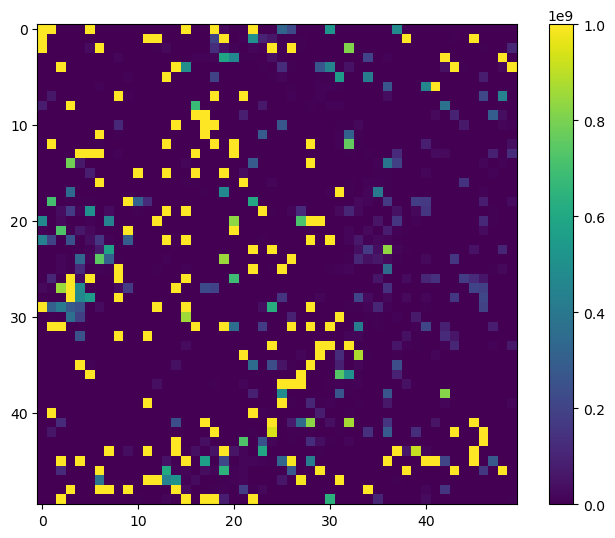

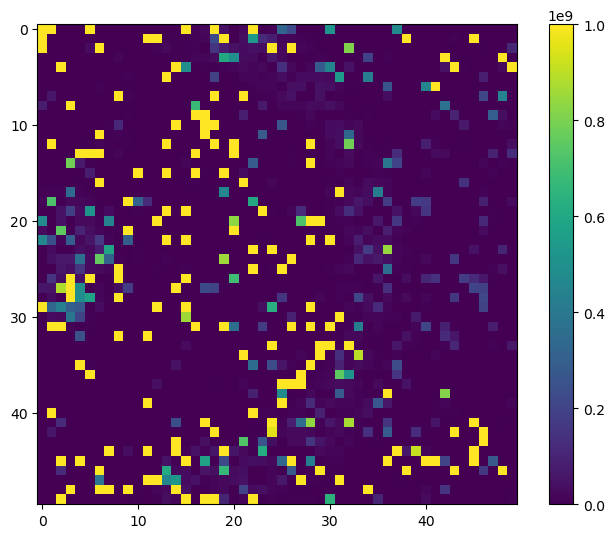

In [26]:
importlib.reload(pu)

pu.plot_matrix(f_back[100:150,100:150,0], clim=[0,1e9])
pu.plot_matrix(f_back_dipy[100:150,100:150,0], clim=[0,1e9])